In [1]:
# Install required packages.
!pip install torch

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.3.1+cu121


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


# Graph Classification with Graph Neural Networks

[Previous: Node Classification with Graph Neural Networks](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX)

In this tutorial session we will have a closer look at how to apply **Graph Neural Networks (GNNs) to the task of graph classification**.
Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.
Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand.

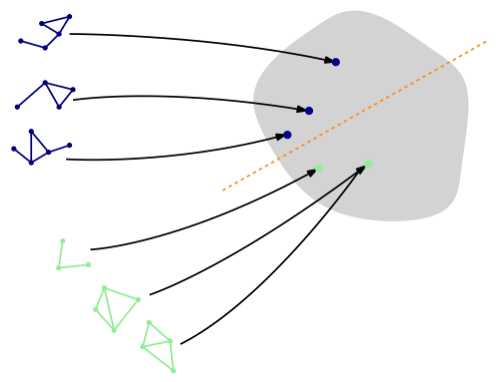

The most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**:

/opt/anaconda3/envs/CSE493G1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


total solution count: 50000
Dataset serialized and saved to '../../data/model-pickle/solutions_dataset_gnn_graphs.pkl'


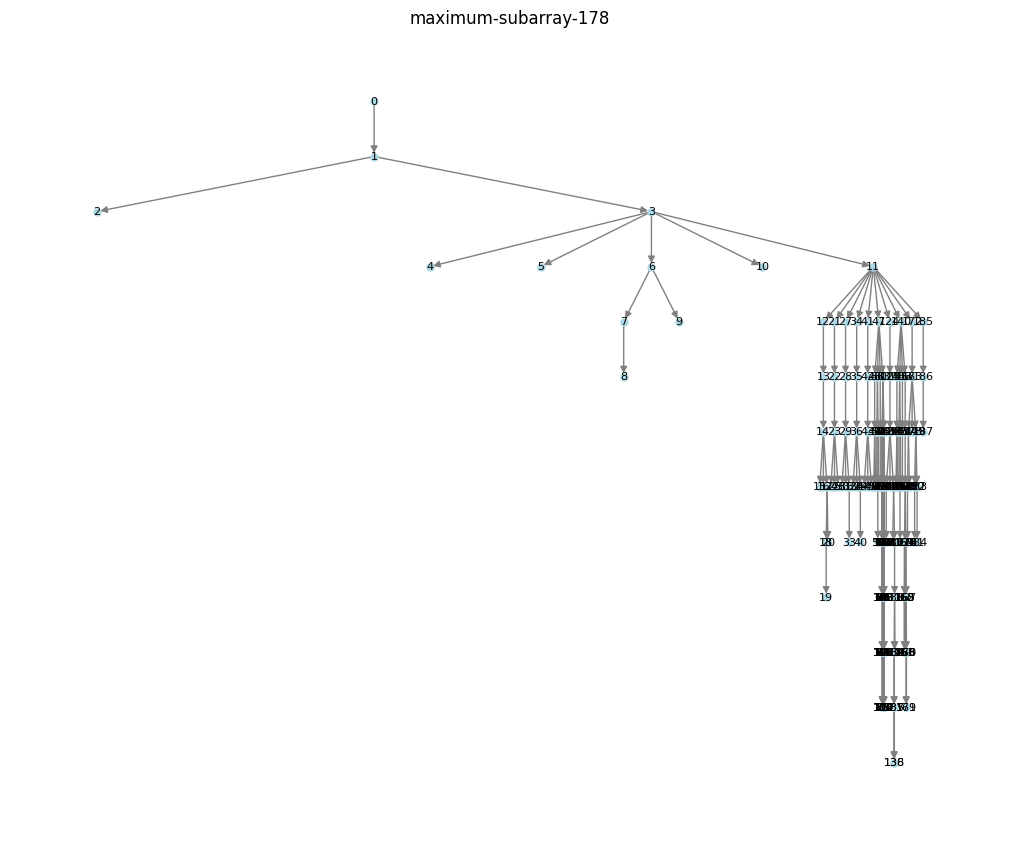

Solution: maximum-subarray-178
Data(edge_index=[2, 187], name=[188], cooccurrences=[188, 139], num_nodes=188, x=[188, 139], y=[100])
Number of nodes: 188
Number of edges: 187
Average node degree: 0.99
Has isolated nodes: False
Has self-loops: False
Is undirected: False
x: tensor([[-0.1187, -0.1187, -0.1187,  ..., -0.1187, -0.1187, -0.1187],
        [-0.1707, -0.1707, -0.1707,  ..., -0.1707, -0.1707, -0.1707],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        ...,
        [-0.1529, -0.1529,  0.0658,  ..., -0.1525, -0.1529, -0.1529],
        [-0.1515, -0.1515,  0.9832,  ...,  0.1190, -0.0980, -0.1515],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231]])
y: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/opt/anaconda3/envs/CSE493G1/lib/python3.10/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  data_dict[key] = torch.as_tensor(value)


In [3]:
# import torch
# import pickle
# from torch_geometric.datasets import TUDataset

# from google.colab import drive
# drive.mount('/content/drive')
# FOLDERNAME = 'cse493g1/project/data'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive

# dataset_path = os.path.join(FOLDERNAME, 'solutions_dataset_gnn_graphs.pkl')
# with open(dataset_path, 'rb') as f:
#     dataset = pickle.load(f)

from construct_gnn_dataset import SolutionDataset

dataset = SolutionDataset(root='../../data/raw')

In [4]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: SolutionDataset(50000):
Number of graphs: 50000
Number of features: 139

Data(edge_index=[2, 200], name=[201], cooccurrences=[201, 139], num_nodes=201, x=[201, 139], y=[100])
Number of nodes: 201
Number of edges: 200
Average node degree: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [5]:
NODE_FEATURES = 139
NUM_CLASSES = 100

In [6]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:45000]
test_dataset = dataset[45000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


Number of training graphs: 45000
Number of test graphs: 5000


In [7]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for step, data in enumerate(train_loader):
    data = data.to(device)
    
    if (step + 1) % 2500 == 0:
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()

Step 2500:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 216], name=[1], cooccurrences=[217, 139], num_nodes=217, x=[217, 139], y=[100], batch=[217], ptr=[2])

Step 5000:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 79], name=[1], cooccurrences=[80, 139], num_nodes=80, x=[80, 139], y=[100], batch=[80], ptr=[2])

Step 7500:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 125], name=[1], cooccurrences=[126, 139], num_nodes=126, x=[126, 139], y=[100], batch=[126], ptr=[2])

Step 10000:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 91], name=[1], cooccurrences=[92, 139], num_nodes=92, x=[92, 139], y=[100], batch=[92], ptr=[2])

Step 12500:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 306], name=[1], cooccurrences=[307, 139], num_nodes=307, x=[307, 139], y=[100], batch=[307], ptr=[2])

Step 15000:
Number of graphs in the current batch: 1
DataBatch(edge_index=[2, 216], name=[1], cooccurrences=

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [8]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(NODE_FEATURES, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, NUM_CLASSES)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)  
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x.squeeze(0) if x.size(0) == 1 else x

model = GCN(hidden_channels=64).to(device) 
print(model)

GCN(
  (conv1): GCNConv(139, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=100, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [ ]:
EPOCHS = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

epoch_losses = {}

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.to(torch.float32))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        _, predicted = torch.max(out, dim=0)
        
    epoch_losses[epoch + 1] = epoch_loss
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

print("Training completed.")

In [ ]:
def test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)  # Forward pass            
            _, predicted = torch.max(out, 0)  # Get the index of the max log-probability
            total += batch.y.size(0)  # Total number of graphs
            correct += (predicted == batch.y).sum().item()  # Correct predictions

    accuracy = correct / total
    return accuracy

test_accuracy = test(model, test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")